In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pathlib
import SimpleITK as sitk
import pickle

In [2]:
# load files
template_file='resampled_template.nii.gz'
prior_file = 'melodic_IC_resampled_resampled.nii.gz'
mask_file = 'masks/sub-jgrAesMEDISOc11L_ses-1_task-rest_acq-EPI_run-1_bold_RAS_EPI_brain_mask.nii.gz'
mask_img = sitk.ReadImage(mask_file)
array_mask = sitk.GetArrayFromImage(mask_img)
volume_indices = array_mask.astype(bool)

DR_prior_map = sitk.GetArrayFromImage(sitk.ReadImage(prior_file))[:,volume_indices][5,:]



### Load all files from REST-AWK mediso group required to conduct analysis QC with mot6_FD

In [4]:
from rabies.confound_correction_pkg.utils import gen_FD_mask
file_list = glob.glob(f'DR_maps/*.nii.gz')
DR_map_list = []
std_maps_list=[]
CR_std_maps_list=[]
mean_FD_list=[]
tdof_list=[]
for file in file_list:
    sub = pathlib.Path(file).name.rsplit("bold")[0]    
    try:    
        temp_file = glob.glob(f'temporal_std/{sub}*')[0]
        std_maps_list.append(sitk.GetArrayFromImage(sitk.Resample(sitk.ReadImage(temp_file), mask_img))[volume_indices])
    except:
        continue
    temp_file = glob.glob(f'CR_std/{sub}*')[0]
    CR_std_maps_list.append(sitk.GetArrayFromImage(sitk.Resample(sitk.ReadImage(temp_file), mask_img))[volume_indices])
    DR_map_list.append(sitk.GetArrayFromImage(sitk.ReadImage(file))[:,volume_indices][5,:])
    
    temp_file = glob.glob(f'FD_csv/{sub}*')[0]
    FD_trace = pd.read_csv(temp_file).get('Mean').to_numpy()
    mask = gen_FD_mask(FD_trace, scrubbing_threshold=0.05)
    mean_FD_list.append(FD_trace[mask].mean())
    tdof_list.append(mask.sum())


### Repeat analysis QC over different sample sizes, 50 iterations per sample size

In [6]:

from rabies.utils import recover_3D
std_maps=np.array(std_maps_list)
non_zero_voxels = ((std_maps==0).sum(axis=0).astype(bool)==0)
non_zero_mask = os.path.abspath('non_zero_mask.nii.gz')
sitk.WriteImage(recover_3D(mask_file, non_zero_voxels.astype(float)), non_zero_mask)

import nilearn.plotting
from rabies.analysis_pkg.diagnosis_pkg.analysis_QC import analysis_QC
length=len(DR_map_list)

sub_sample_dict = {}

FC_maps = np.array(DR_map_list)
prior_map = DR_prior_map[non_zero_voxels]

sub_sample_dict={}
for n in [5,10,15,20,30]:
    print(n)
    num_iter=50
    measure_list=[]
    for j in range(num_iter):
        idx = np.random.choice(length, n, replace=False)
        FC_subset = FC_maps[idx,:][:,non_zero_voxels]
        CR_std_maps=np.array(CR_std_maps_list)[idx,:][:,non_zero_voxels]

        corr_variable = [CR_std_maps, np.array(mean_FD_list)[idx].reshape(-1,1), np.array(tdof_list)[idx].reshape(-1,1)]
        variable_name = ['CRsd', 'FD', 'tDOF']            
        dataset_stats,fig,fig_unthresholded = analysis_QC(FC_subset, prior_map, non_zero_mask, corr_variable, variable_name, template_file, non_parametric=False)
        plt.close(fig)
        plt.close(fig_unthresholded)


        measure_list.append(dataset_stats)

        if j%10==0:
            print(j)
    sub_sample_dict[str(n)]=measure_list
        

data_file = 'sub_sample_dict.pkl'
with open(data_file, 'wb') as handle:
    pickle.dump(sub_sample_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


5


/home/gabriel/miniconda3/envs/rabies_analysis_repro/lib/python3.9/site-packages/rabies/analysis_pkg/analysis_math.py:20: RuntimeWarning: invalid value encountered in true_divide
  r = r_num/r_den


0
10
20
30
40
10
0
10
20
30
40
15
0
10
20
30
40
20
0
10
20
30
40
30
0
10
20
30
40


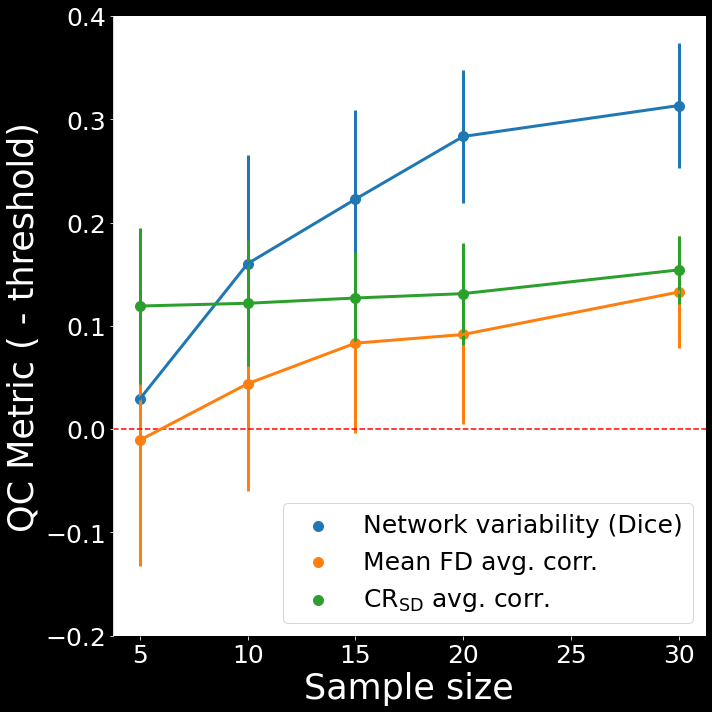

In [8]:

data_file = 'sub_sample_dict.pkl'
with open(data_file, 'rb') as handle:
    sub_sample_dict = pickle.load(handle)

measure_keys=['Network variability (Dice)',
   'Mean FD avg. corr.',
   '$\mathregular{CR_{SD}}$ avg. corr.']

FC = 'S1N - DR'

#fig,axes=plt.subplots(2,2, figsize=(20,20))
fig,ax=plt.subplots(1,1, figsize=(10,10))
x=[5,10,15,20,30]


y=[]
y_err=[]
for n in x:
    measure_list = sub_sample_dict[str(n)]
    y_list=[]
    for measures in measure_list:
        STD_spec = measures['Overlap: Prior - Dataset STD']
        CR_effect = np.abs(measures['Avg.: CRsd'])
        FD_effect = np.abs(measures['Avg.: FD'])

        STD_spec_res = STD_spec - 0.3
        CR_effect_res = 0.2 - CR_effect
        FD_effect_res = 0.2 - FD_effect
        y_list.append([STD_spec_res, FD_effect_res, CR_effect_res])
    y.append(np.array(y_list).mean(axis=0))
    y_err.append(np.array(y_list).std(axis=0))
y=np.array(y)
y_err=np.array(y_err)
for i in range(3):
    ax.scatter(x,y[:,i], s=100)
    ax.errorbar(x,y[:,i],yerr=y_err[:,i], linewidth=3)            

ax.set_ylim([-0.2,0.4])
ax.set_ylabel('QC Metric ( - threshold)', fontsize=35)
ax.set_xlabel('Sample size', fontsize=35)
ax.legend(measure_keys, fontsize=25,
           loc='lower right')#, bbox_to_anchor=(1, 0.3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)

ax.axhline(y=0.0, color='r', linestyle='--')
plt.tight_layout()
